# Description <a id='top'></a>

CSFAIL.LIVE is a site for CS:GO skin trading, with certain features and opportunities for users.
One of the opportunities is gambling game https://csfail.live/en/crash.
The recource generates quite a lot of not very sophisticated data.
Although it does not have any API the data is not protected from collecting using Selenium library.

# Contents
### 1. Collecting  and pre-processing data
Table **bets** contains information about bets made by players. Player makes a stake and choose BetRatio. Afterwards if the BetRatio appeares less than Ratio coefficient chosen by the game service the players receives Stake * BetRatio win. If BetRatio appeares not less than Ratio coefficient chosen by the game service the player looses his Stake.

[bets](#bets)    

Table **rounds** contains information about [rounds](#rounds)
### 2. Features generating 
[players](#players_features)  [hours](#hours_features)
### 3. Players investigation
 [HeatMap](#players_heatmap)    [Clustering](#players_clustering)
### 4. Hours investigation

 [Plots](#hours_values)       [HeatMap](#hours_heatmap)





In [42]:
import pandas as pd
import time
import datetime
import matplotlib_inline
import pickle
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [43]:
with open('./csfail_rounds_w_persons.pkl', 'rb') as f:
    bets = pickle.load(f)
bets.rename(columns={"Ratio" : "BetRatio"}, inplace=True)

with open('./csfail_history.pkl', 'rb') as f:
    rounds = pickle.load(f)

### Collecting  and preprocessing data 
#### bets <a id='bets'></a>[top](#top)

| Feature | Commentary |
| ----------- | ----------- |
| 'Round'| Round number|
| 'Stake'  | Stake done   |
|'Win'|Win or loss|
|'BetRatio'|Ratio chosen by the player|
|'Player'| Unique name of player|

#### rounds <a id='rounds'></a>[top](#top)

| Feature | Commentary |
| ----------- | ----------- |
| 'Round'| Round number|
| 'Time' | Time of round   |
|'GrabDate'|Date when data were collected|
|'Bank'|Sum of all stakes of the round|
|'PersonsNumber'| Number of participants|
|'Ratio'| Ratio states by service|



In [40]:
df = pd.merge(bets, rounds, on="Round")


df["BankCalculated"] = df.groupby('Round')["Stake"].transform('sum')
df["CurrencyRate"] = df["BankCalculated"] / df["Bank"]
df["StakeUSD"] = df["Stake"] / df["CurrencyRate"]
df["WinCalculated"] = df["StakeUSD"] * df["BetRatio"] * (df["Ratio"] > df["BetRatio"]) - df["StakeUSD"]
df["WinCalculatedCumulative"] = df.groupby("Player")["WinCalculated"].cumsum()
df["AverageStake"] = df.groupby('Player')["StakeUSD"].transform('mean')
df["AverageParticipants"] = df.groupby('Player')["PersonsNumber"].transform('mean')
df["AverageBetRatio"] = df.groupby('Player')["BetRatio"].transform('mean')
df["StdStake"] = df.groupby('Player')["StakeUSD"].transform('std')
df["StdParticipants"] = df.groupby('Player')["PersonsNumber"].transform('std')
df["StdBetRatio"] = df.groupby('Player')["BetRatio"].transform('std')
df["Hour"] = pd.to_datetime(df["Time"]).dt.hour

df['StdStake'] = df['StdStake'].fillna(0.)
df['StdParticipants'] = df['StdParticipants'].fillna(0.)
df['StdBetRatio'] = df['StdBetRatio'].fillna(0.)



### Hours features generation <a id='hours_features'></a>[top](#top)

| Feature | Commentary |
| ----------- | ----------- |
| 'AverageProfit'| Average win in the hour|
| 'MinBetWin' | Minimum round win in the hour   |
| 'MaxBetWin' | Maximum round win in the hour    |
|'MaxCumulativeWin'|Maximum cumulative win in the hour   |
|'MinCumulativeWin'|Minimum cumulative win in the hour  |
|'AverageStake'| Average stake in the hour  |
|'AverageParticipants'| Average participants number in the hour|
|'AverageBetRatio'| Average bet ratio in the hour|
|'StdStake'| STD of stake in the hour|
|'StdParticipants'| STD of participants number in the hour|
|'StdBetRatio'| STD of bet ratio in the hour|


In [41]:
hours = df.groupby('Hour').agg(
    AverageProfit=pd.NamedAgg(column='WinCalculated', aggfunc='mean'),
    MinBetWin=pd.NamedAgg(column='WinCalculated', aggfunc='min'),
    MaxCumulativeWin=pd.NamedAgg(column='WinCalculatedCumulative', aggfunc='max'),
    MinCumulativeWin=pd.NamedAgg(column='WinCalculatedCumulative', aggfunc='min'),
    MaxBetWin=pd.NamedAgg(column='WinCalculated', aggfunc='max'),
    MinDate=pd.NamedAgg(column='GrabDate', aggfunc='min'),
    MaxDate=pd.NamedAgg(column='GrabDate', aggfunc='max'),
    AverageStake=pd.NamedAgg(column='AverageStake', aggfunc='max'),
    AverageParticipants=pd.NamedAgg(column='AverageParticipants', aggfunc='max'),
    AverageBetRatio=pd.NamedAgg(column='AverageBetRatio', aggfunc='max'),
    StdStake=pd.NamedAgg(column='StdStake', aggfunc='max'),
    StdParticipants=pd.NamedAgg(column='StdParticipants', aggfunc='max'),
    StdBetRatio=pd.NamedAgg(column='StdBetRatio', aggfunc='max'),
    
)


### Values by hours  <a id='hours_values'></a> [top](#top)

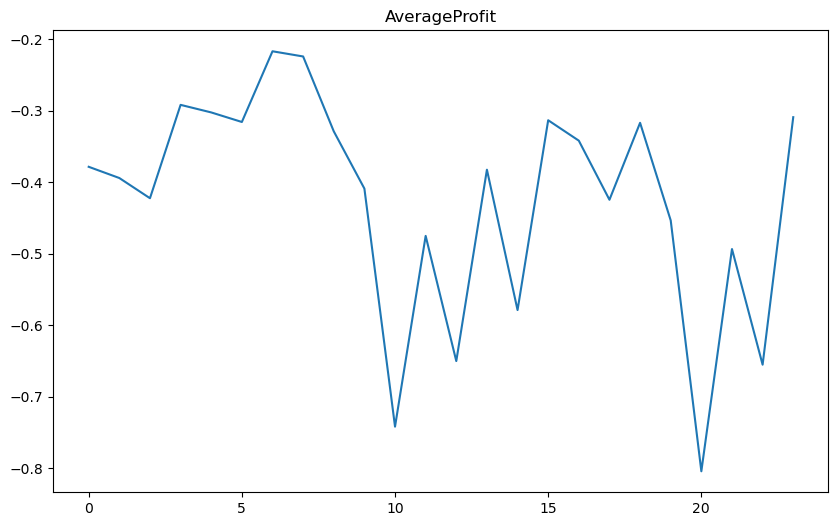

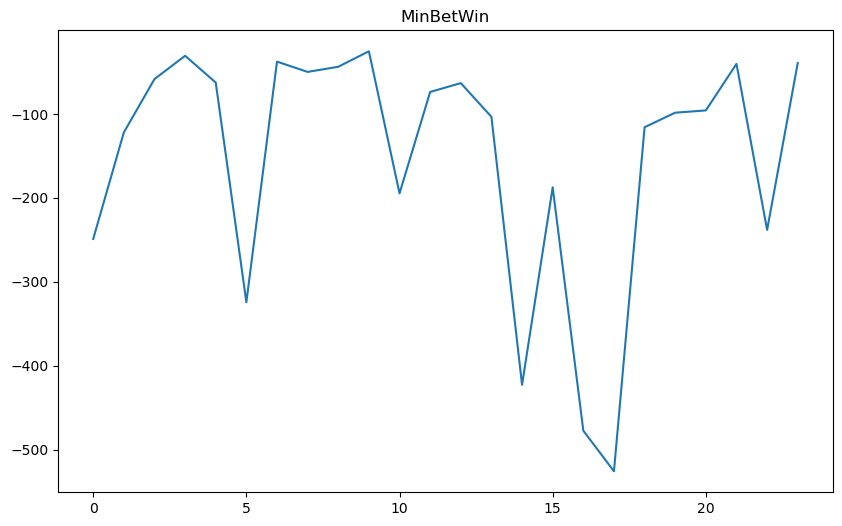

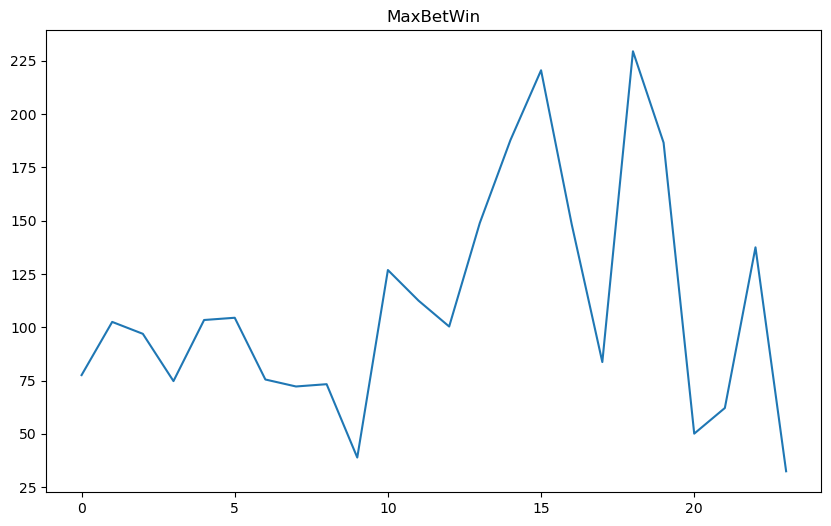

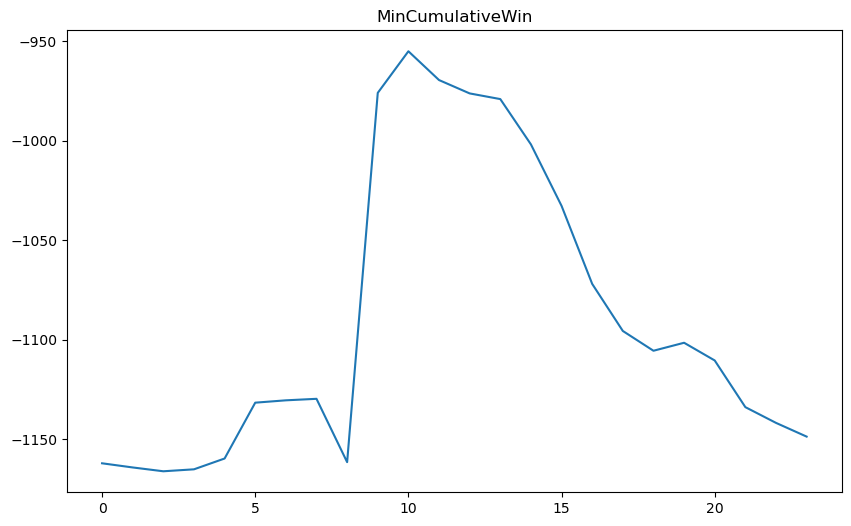

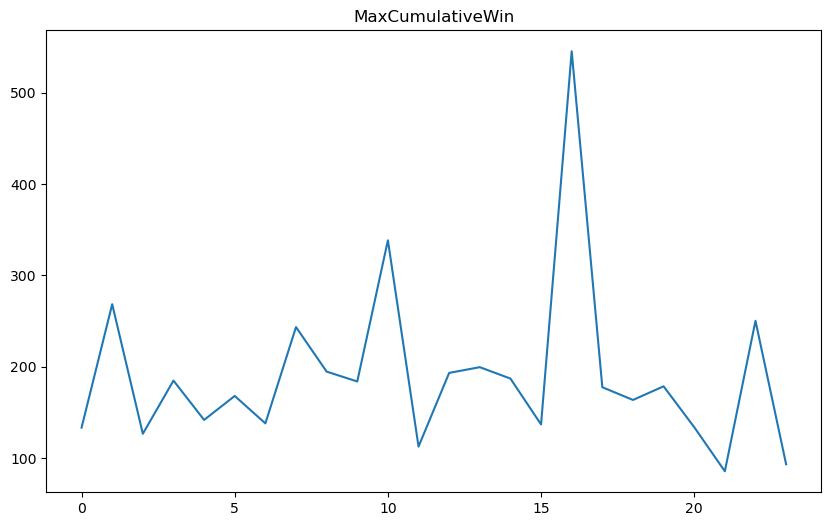

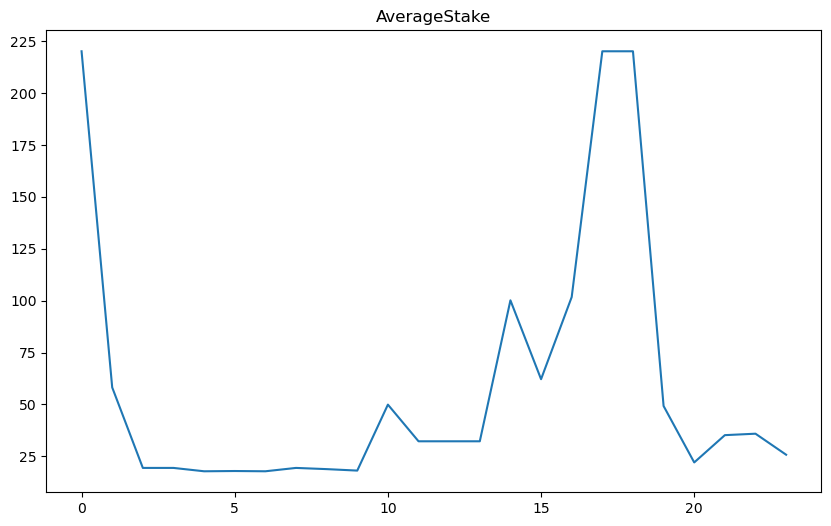

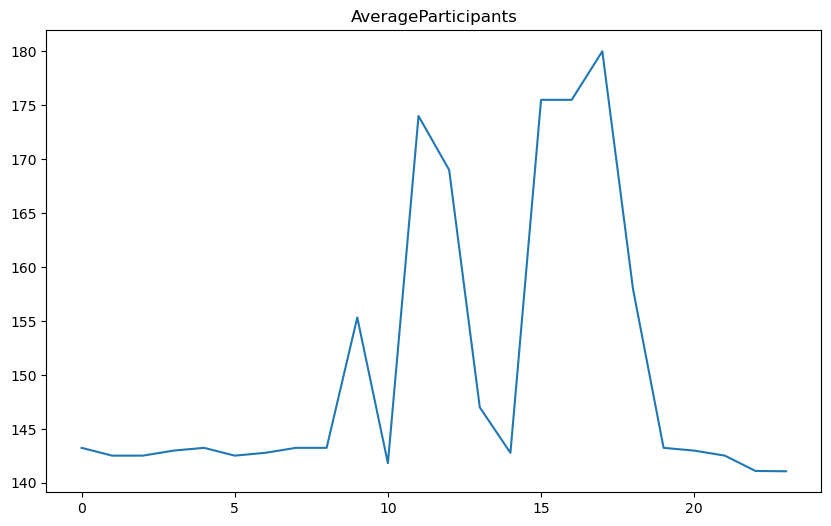

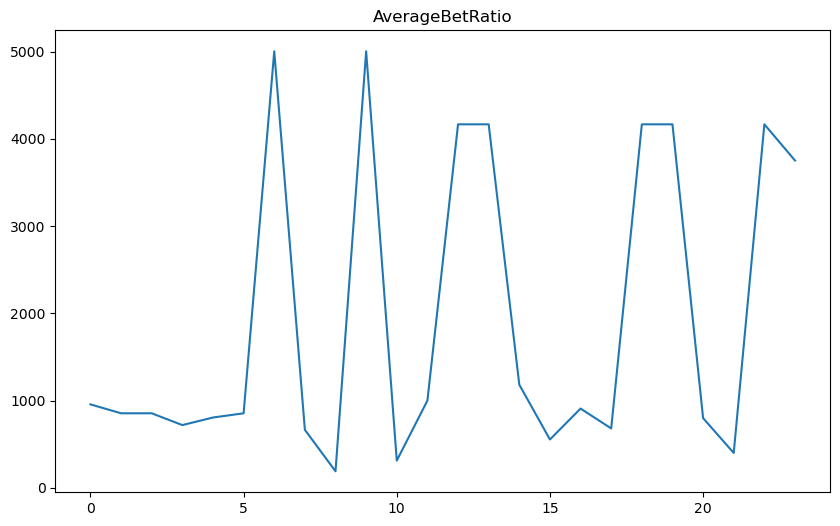

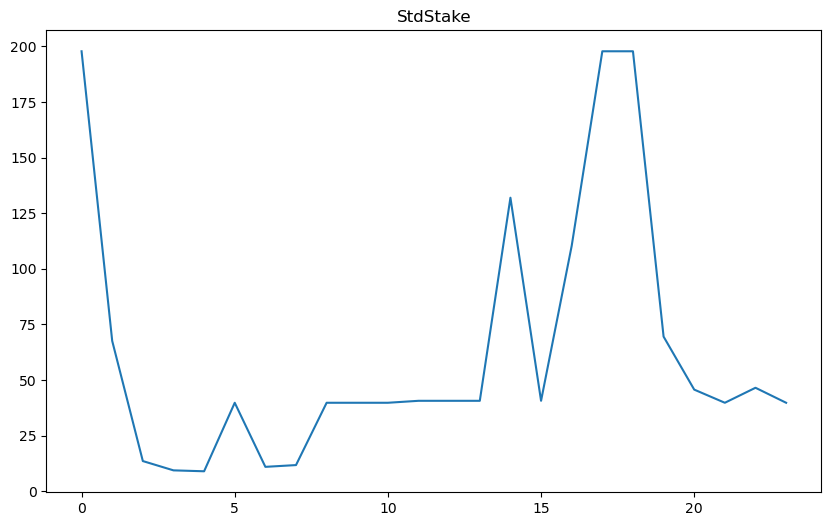

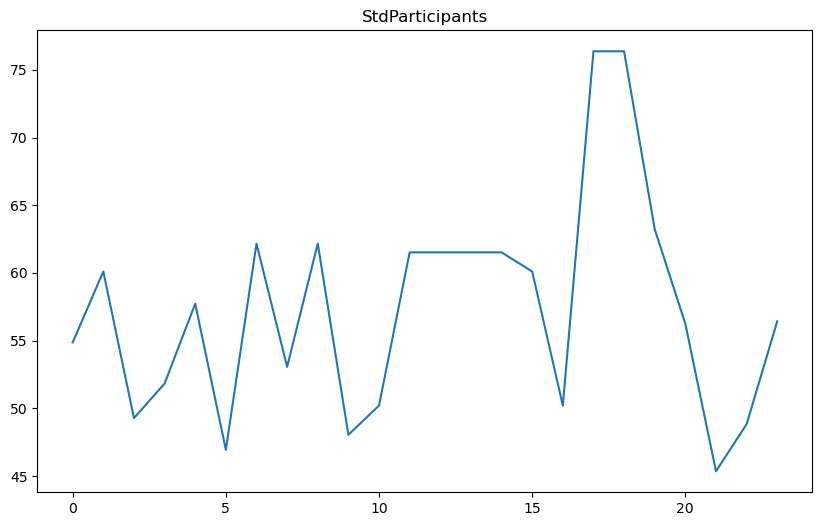

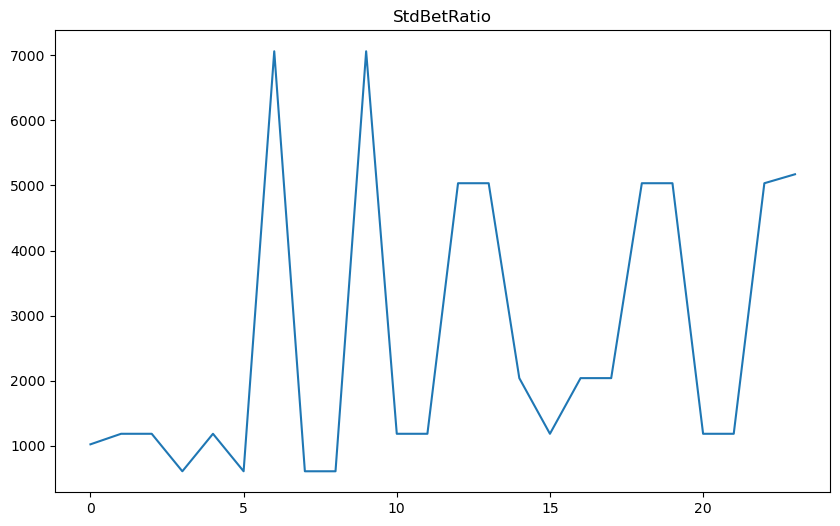

In [38]:
selected_columns = ['AverageProfit', 'MinBetWin', 'MaxBetWin', 'MinCumulativeWin', 
                    'MaxCumulativeWin', 'AverageStake', 'AverageParticipants', 'AverageBetRatio', 
                    'StdStake', 'StdParticipants', 'StdBetRatio']

for column in selected_columns:
    plt.figure(figsize=(10,6))
    plt.title(column)
    plt.plot(hours[column])
    plt.show()

### Hours heatmap  <a id='hours_heatmap'></a> [top](#top)

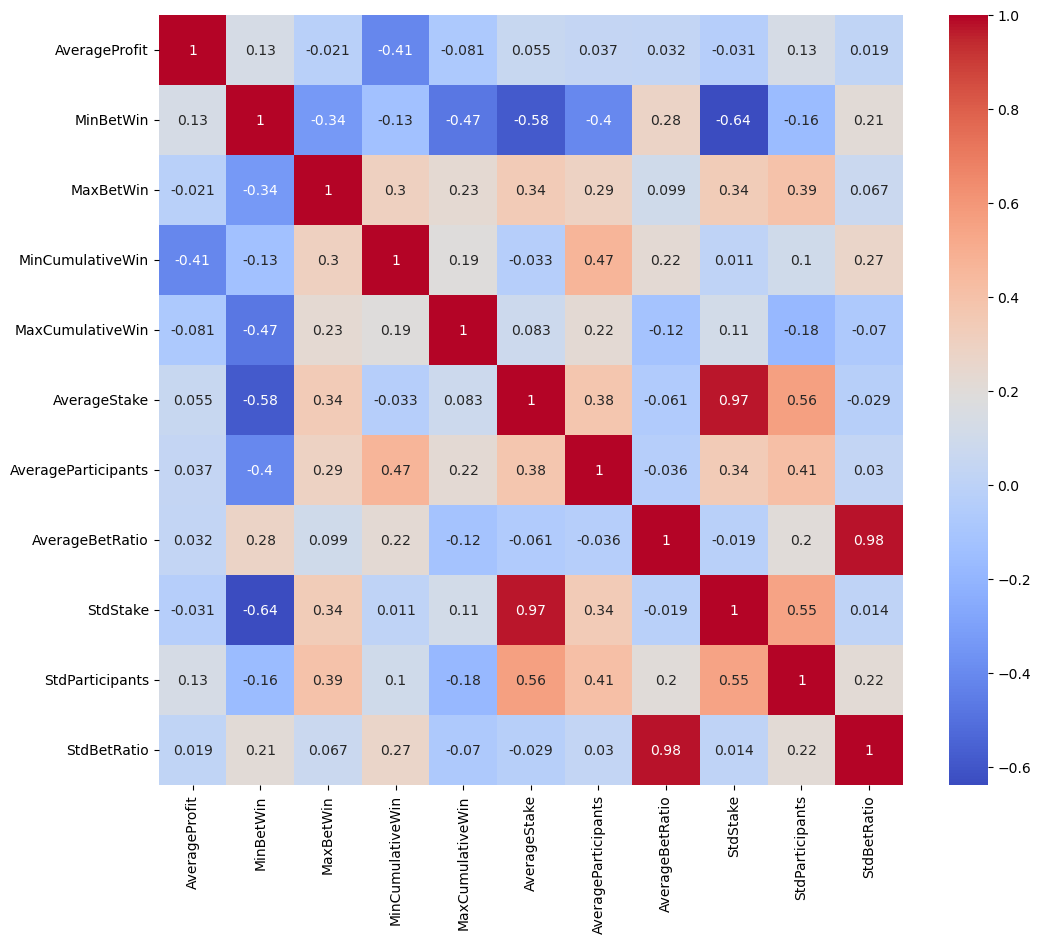

In [22]:
selected_columns = ['AverageProfit', 'MinBetWin', 'MaxBetWin', 'MinCumulativeWin', 
                    'MaxCumulativeWin', 'MinDate', 'MaxDate', 
                    'AverageStake', 'AverageParticipants', 'AverageBetRatio', 
                    'StdStake', 'StdParticipants', 'StdBetRatio']

correlation_matrix = hours[selected_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Players features generating  <a id='players_features'></a> [top](#top)

| Feature | Commentary |
| ----------- | ----------- |
| 'Profit'| Win of the player|
| 'Count'| Number of rounds of the player|
| 'MinBetWin' | Minimum round win of the player  |
| 'MaxBetWin' | Maximum round win of the player   |
|'MaxCumulativeWin'|Maximum cumulative win of the player  |
|'MinCumulativeWin'|Minimum cumulative win of the player |
|'AverageStake'| Average stake of the player|
|'AverageParticipants'| Average participants number of the player|
|'AverageBetRatio'| Average bet ratio of the player|
|'StdStake'| STD of stake of the player|
|'StdParticipants'| STD of participants number of the player|
|'StdBetRatio'| STD of bet ratio of the player|



In [19]:
#players = df.groupby('Player')["WinCalculated"].sum()
players = df.groupby('Player').agg(
    Profit=pd.NamedAgg(column='WinCalculated', aggfunc='sum'),
    Count=pd.NamedAgg(column='WinCalculated', aggfunc='count'),
    MinBetWin=pd.NamedAgg(column='WinCalculated', aggfunc='min'),
    MaxCumulativeWin=pd.NamedAgg(column='WinCalculatedCumulative', aggfunc='max'),
    MinCumulativeWin=pd.NamedAgg(column='WinCalculatedCumulative', aggfunc='min'),
    MaxBetWin=pd.NamedAgg(column='WinCalculated', aggfunc='max'),
    MinDate=pd.NamedAgg(column='GrabDate', aggfunc='min'),
    MaxDate=pd.NamedAgg(column='GrabDate', aggfunc='max'),
    AverageStake=pd.NamedAgg(column='AverageStake', aggfunc='max'),
    AverageParticipants=pd.NamedAgg(column='AverageParticipants', aggfunc='max'),
    AverageBetRatio=pd.NamedAgg(column='AverageBetRatio', aggfunc='max'),
    StdStake=pd.NamedAgg(column='StdStake', aggfunc='max'),
    StdParticipants=pd.NamedAgg(column='StdParticipants', aggfunc='max'),
    StdBetRatio=pd.NamedAgg(column='StdBetRatio', aggfunc='max'),
    
)


print(players.head())
print(players.describe())
print(players.columns)



                                                       Profit  Count  \
Player                                                                 
https://avatars.mds.yandex.net/get-yapic/32838/...  -5.354816     22   
https://avatars.steamstatic.com/00017636082e569...   1.055000      5   
https://avatars.steamstatic.com/00092505e95f7e2... -53.758558     57   
https://avatars.steamstatic.com/000a6a178de64d1...  -1.189479      5   
https://avatars.steamstatic.com/001245ff7927000... -27.249648     99   

                                                    MinBetWin  \
Player                                                          
https://avatars.mds.yandex.net/get-yapic/32838/...  -1.850000   
https://avatars.steamstatic.com/00017636082e569...  -0.310000   
https://avatars.steamstatic.com/00092505e95f7e2...  -3.694587   
https://avatars.steamstatic.com/000a6a178de64d1...  -0.750280   
https://avatars.steamstatic.com/001245ff7927000...  -3.464898   

                                       

### Players heatmap  <a id='players_heatmap'></a> [top](#top)

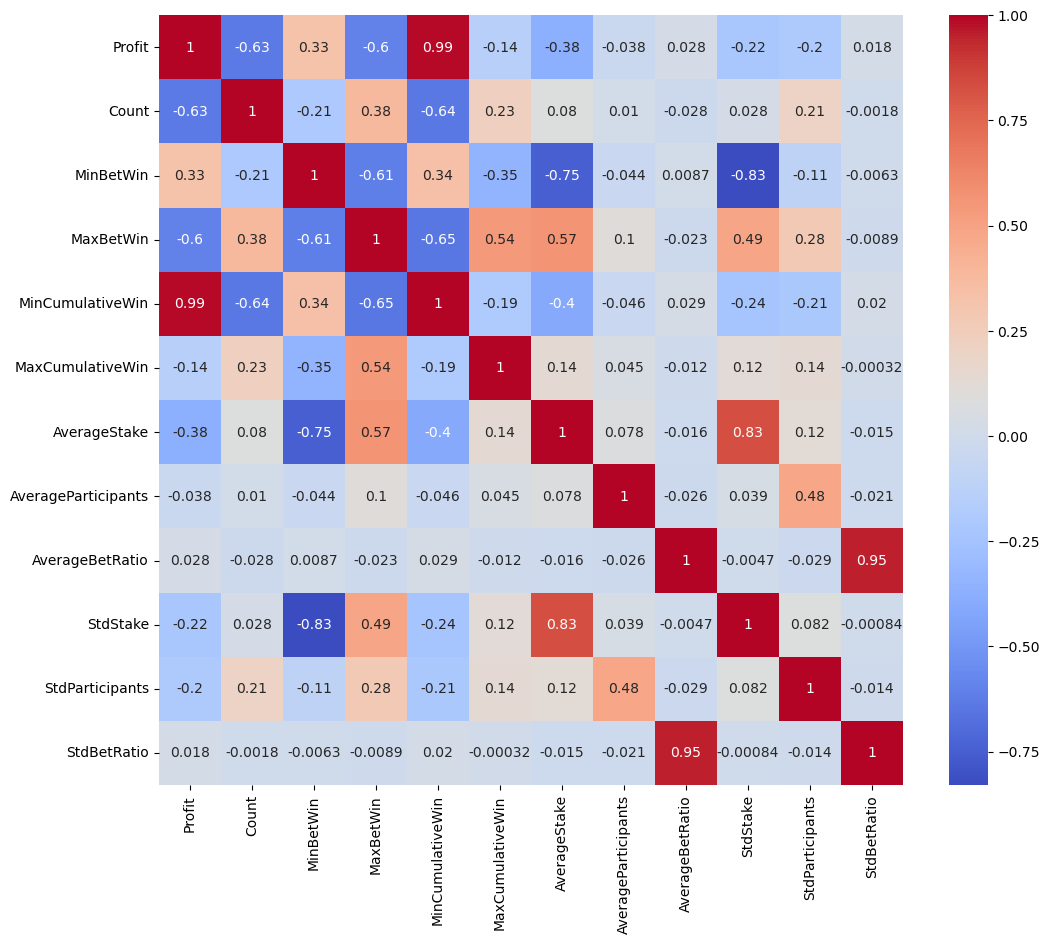

In [26]:
selected_columns = ['Profit', 'Count', 'MinBetWin', 'MaxBetWin', 'MinCumulativeWin', 
                    'MaxCumulativeWin','AverageStake', 'AverageParticipants', 'AverageBetRatio', 
                    'StdStake', 'StdParticipants', 'StdBetRatio']

correlation_matrix = players[selected_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Players clustering  <a id='players_clustering'></a> [top](#top)

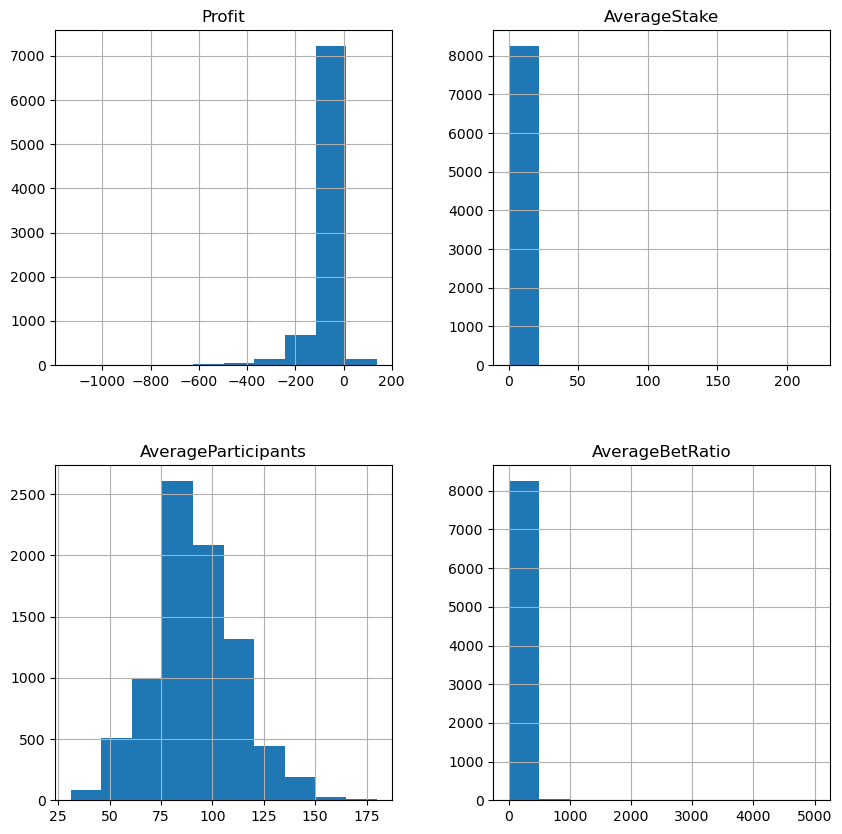

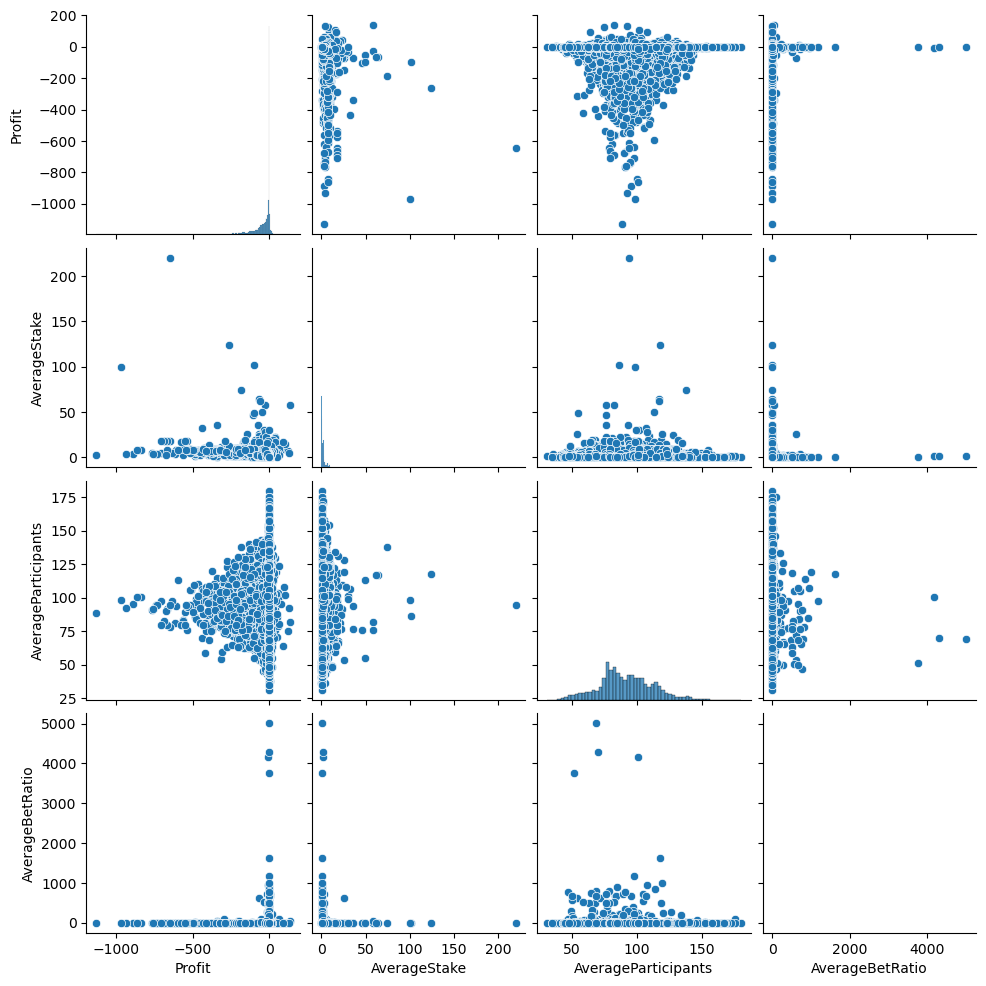

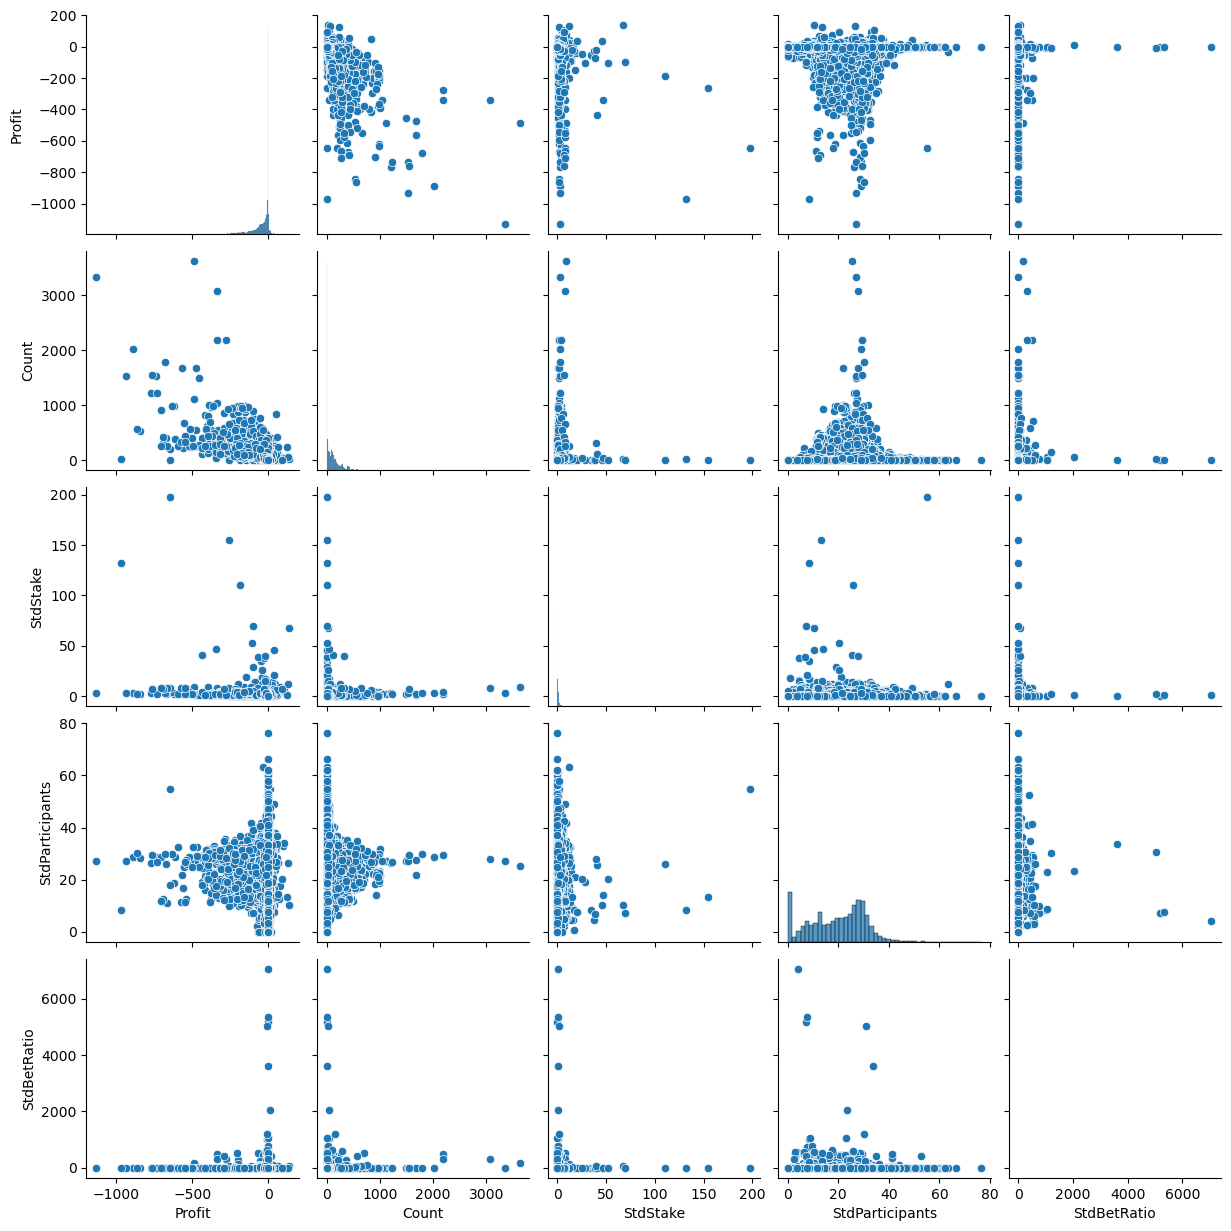

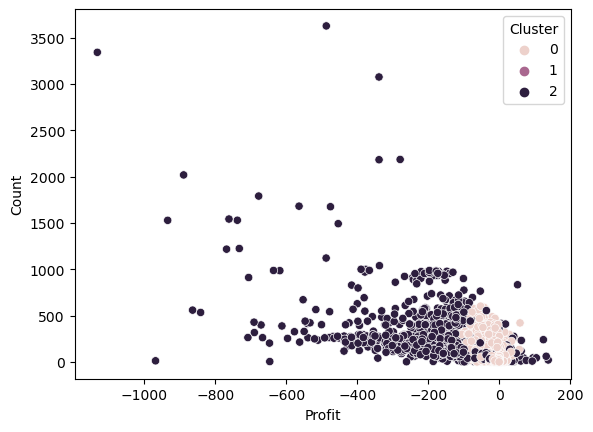

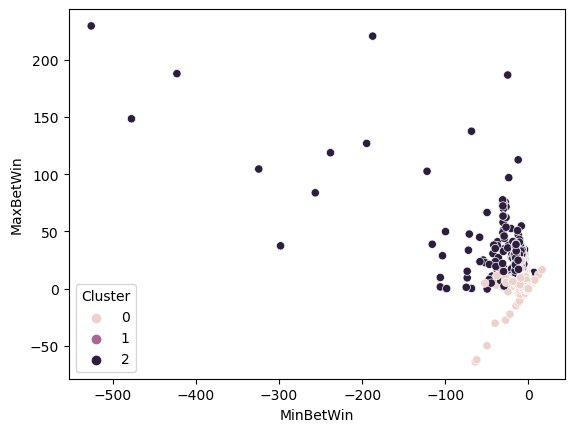

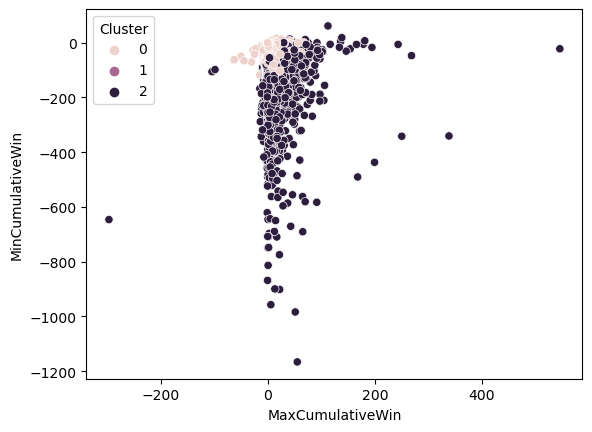

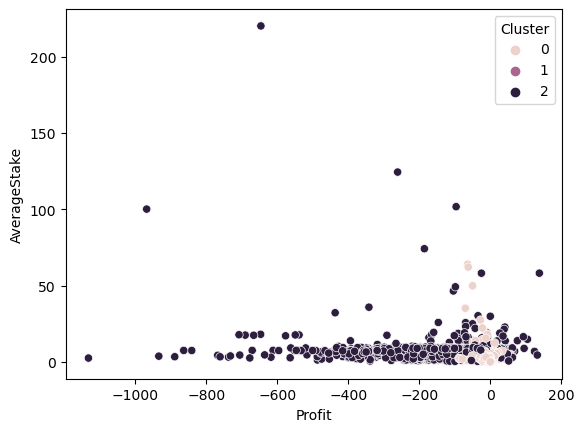

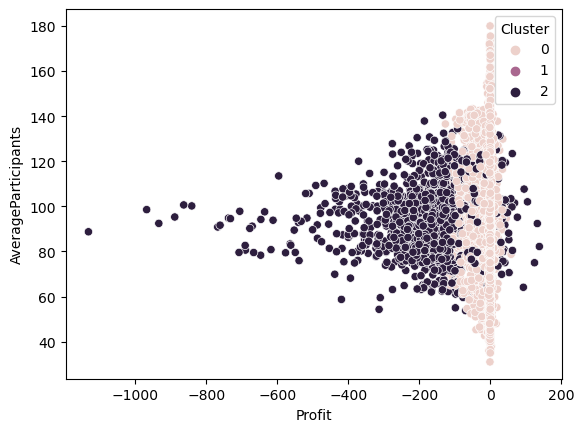

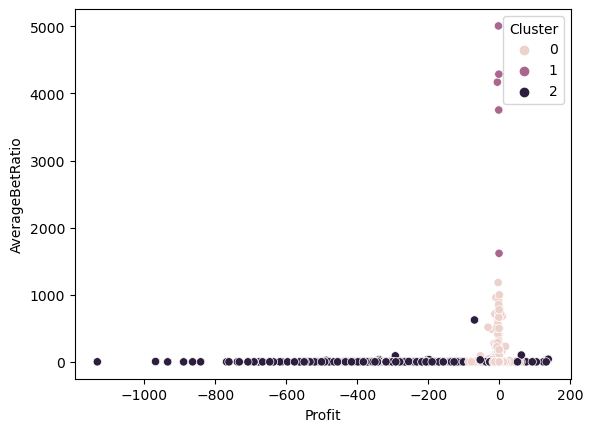

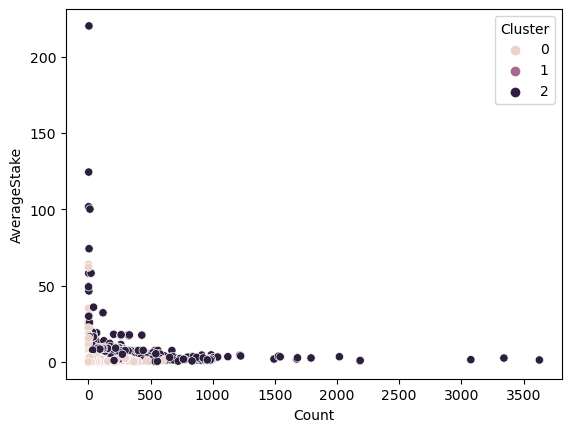

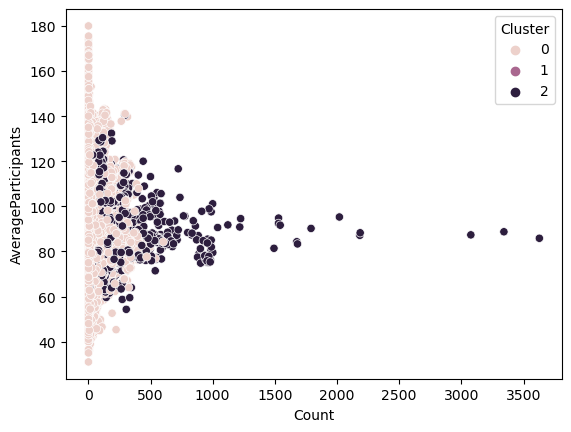

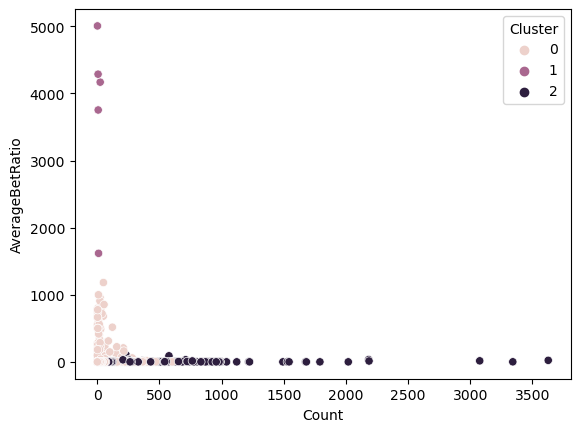

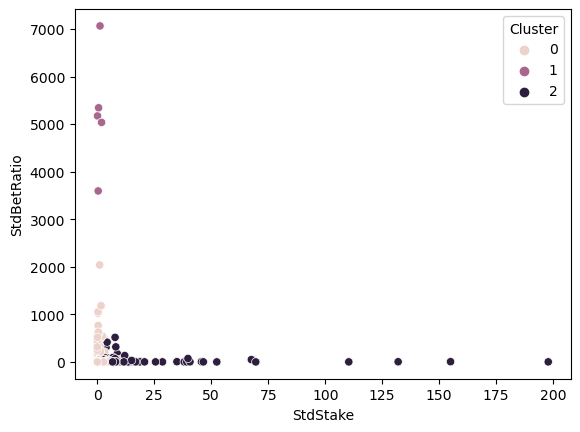

Empty DataFrame
Columns: [Profit, Count, MinBetWin, MaxCumulativeWin, MinCumulativeWin, MaxBetWin, MinDate, MaxDate, AverageStake, AverageParticipants, AverageBetRatio, StdStake, StdParticipants, StdBetRatio, Cluster]
Index: []


In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Assume players is your dataframe
# players = pd.read_csv('your_data.csv')

# Visualize data
players[['Profit', 'AverageStake', 'AverageParticipants', 'AverageBetRatio']].hist(figsize=(10, 10))
plt.show()

sns.pairplot(players[['Profit', 'AverageStake', 'AverageParticipants', 'AverageBetRatio']])
plt.show()

sns.pairplot(players[['Profit', 'Count', 'StdStake', 'StdParticipants', 'StdBetRatio']])
plt.show()

# Prepare data for clustering
features = ['Profit', 'Count', 'MinBetWin', 'MaxBetWin', 'MaxCumulativeWin', 'MinCumulativeWin', 'AverageStake', 
             'AverageParticipants', 'AverageBetRatio', 'StdStake', 'StdParticipants', 'StdBetRatio']
X = players[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_scaled)


# Add clusters to dataframe
players['Cluster'] = clusters

# Visualize clusters
sns.scatterplot(x='Profit', y='Count', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='MinBetWin', y='MaxBetWin', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='MaxCumulativeWin', y='MinCumulativeWin', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageStake', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageParticipants', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageBetRatio', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Count', y='AverageStake', hue='Cluster', data=players)
plt.show()



# Visualize clusters
sns.scatterplot(x='Count', y='AverageParticipants', hue='Cluster', data=players)
plt.show()


# Visualize clusters
sns.scatterplot(x='Count', y='AverageBetRatio', hue='Cluster', data=players)
plt.show()


# Visualize clusters
sns.scatterplot(x='StdStake', y='StdBetRatio', hue='Cluster', data=players)
plt.show()

# Identify potentially anomalous players
anomalous_players = players[players['Cluster'] == kmeans.cluster_centers_.argmin()]
print(anomalous_players)


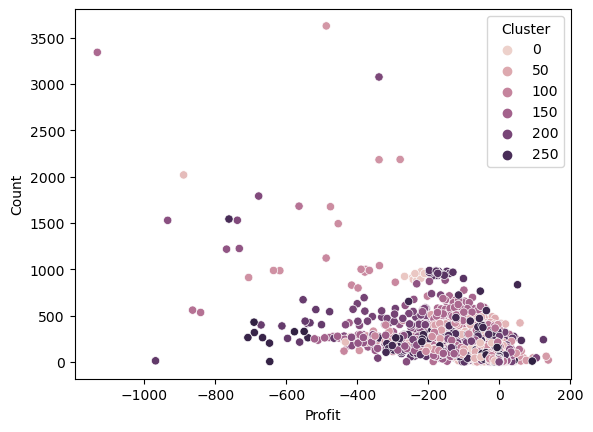

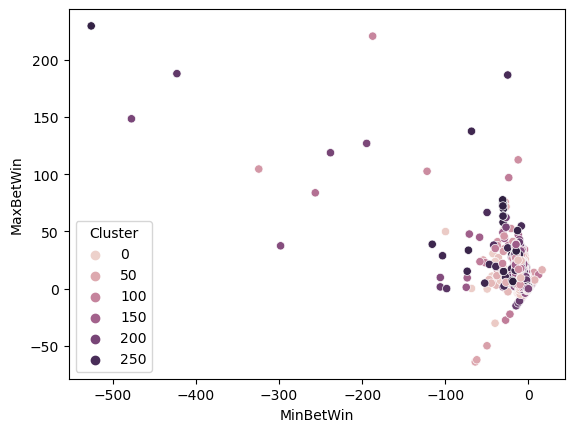

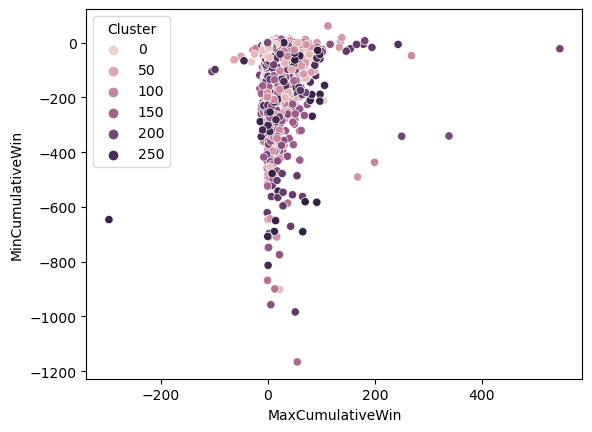

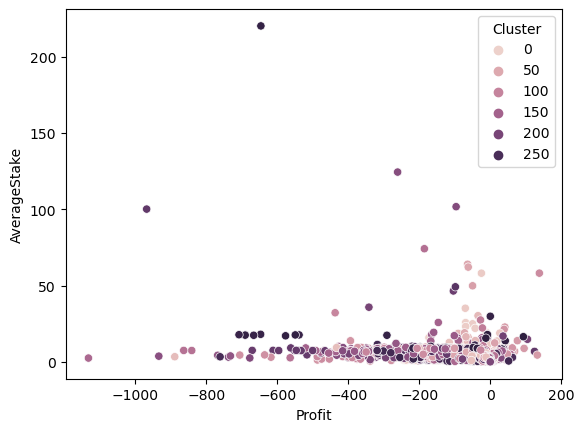

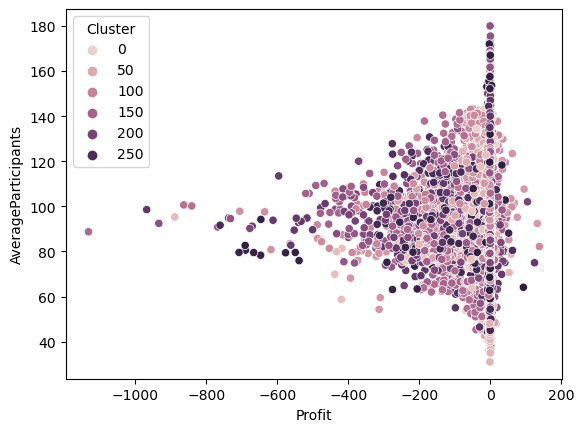

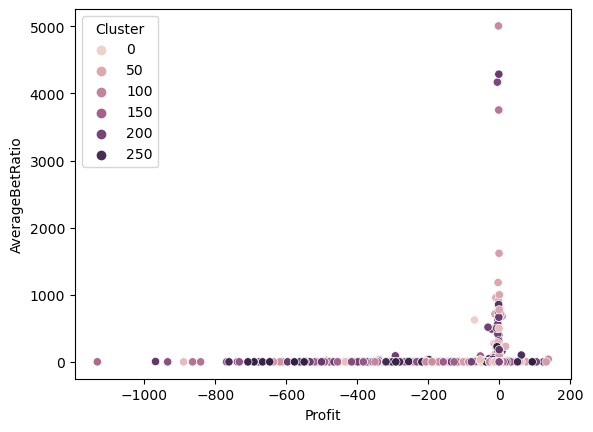

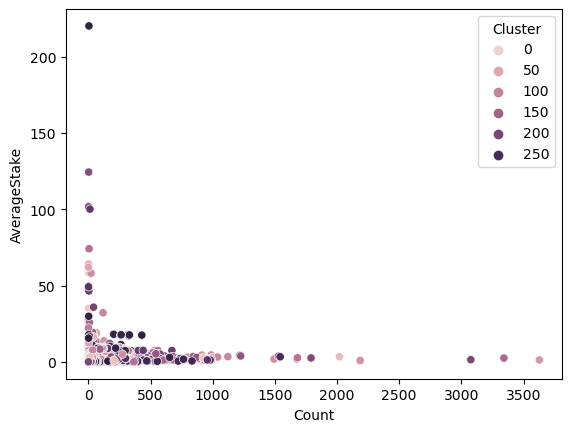

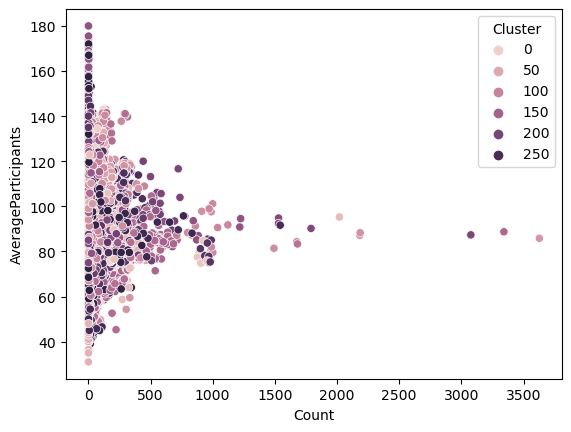

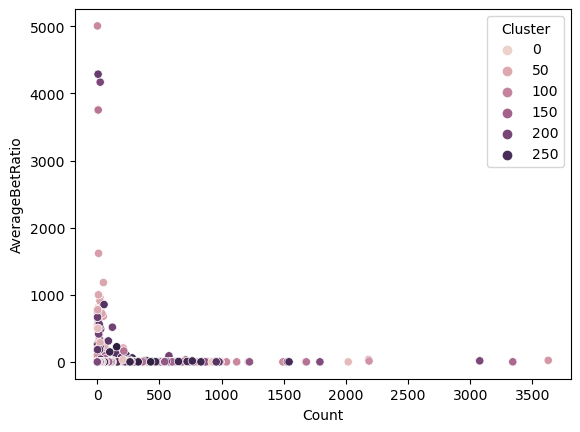

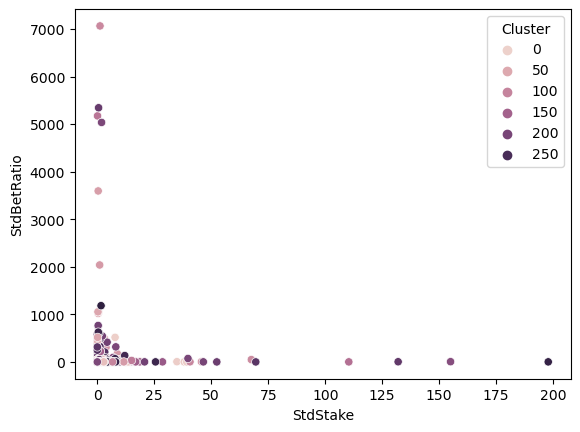

                                                       Profit  Count  \
Player                                                                 
https://avatars.steamstatic.com/03b3995b9776363...  -1.198000      5   
https://avatars.steamstatic.com/0d7e236a3a6f63f...  -0.045000      2   
https://avatars.steamstatic.com/114306bccc32c40...  -0.220000      2   
https://avatars.steamstatic.com/15110f8d2c3ad6f...  -2.303000      2   
https://avatars.steamstatic.com/19ccedbf7de7772...   1.070323      4   
https://avatars.steamstatic.com/46d3dc44a52ce13...  10.599960      3   
https://avatars.steamstatic.com/49c337d507e9255...  -0.270000      2   
https://avatars.steamstatic.com/4f0300f149ec4a3...  -2.610000      2   
https://avatars.steamstatic.com/5255de3b7f8464a...  -2.509000      4   
https://avatars.steamstatic.com/52b80fdcc4cfd90...  -1.020000      3   
https://avatars.steamstatic.com/64d47ad503e5f46...   0.390000      2   
https://avatars.steamstatic.com/7517816a47eaa61...  -1.390000   

In [124]:
from sklearn.cluster import AffinityPropagation
# Perform clustering
aff = AffinityPropagation(random_state=0)
clusters = aff.fit_predict(X_scaled)


# Add clusters to dataframe
players['Cluster'] = clusters

# Visualize clusters
sns.scatterplot(x='Profit', y='Count', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='MinBetWin', y='MaxBetWin', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='MaxCumulativeWin', y='MinCumulativeWin', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageStake', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageParticipants', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Profit', y='AverageBetRatio', hue='Cluster', data=players)
plt.show()

# Visualize clusters
sns.scatterplot(x='Count', y='AverageStake', hue='Cluster', data=players)
plt.show()



# Visualize clusters
sns.scatterplot(x='Count', y='AverageParticipants', hue='Cluster', data=players)
plt.show()


# Visualize clusters
sns.scatterplot(x='Count', y='AverageBetRatio', hue='Cluster', data=players)
plt.show()


# Visualize clusters
sns.scatterplot(x='StdStake', y='StdBetRatio', hue='Cluster', data=players)
plt.show()

# Identify potentially anomalous players
anomalous_players = players[players['Cluster'] == kmeans.cluster_centers_.argmin()]
print(anomalous_players)
